# ATE computations from Baysian Networks in Observational Data

*This notebook aims to study the capabilities of Bayesian Networks for computing Average Treatment Effects (ATE) from Observational Data under the Neyman-Rubin potential outcome framework.*

In contrast to randomized controlled trials (RCTs) where the ignorability assumption is inherently satisfied, estimating treatment effects from observational data introduces additional complexities.
Under RCT conditions, an unbiased estimator of the Average Treatment Effect (ATE) can be effectively computed by comparing the means of the observed treated subjects and the observed untreated subjects.

Specifically, the Stable-Unit-Treatment-Value Assumption (STUVA) posits that $ Y = (1-T)Y(0) + TY(1) $ and under the ignorability assumption, $ T \perp\!\!\!\perp \{Y(0), Y(1)\} $. 

Therefore the ATE is given by 
$$\begin{align*}
\mathbb{E}[Y(1)] - \mathbb{E}[Y(0)] &= \mathbb{E} [Y(1)|T=1] - \mathbb{E} [Y(0)|T=0] & \mathrm{(Ignorability)}\\
&= \mathbb{E}[Y|T=1] - \mathbb{E}[Y|T=0] & \mathrm{(SUTVA)}
\end{align*}$$

and the latter can be estimated directly from the data.

However, in observational data, the ignorability assumption often does not hold, as subjects with certain treatment outcomes may be more or less likely to receive the treatment (i.e. $ \mathbb{E}[Y(t)|T=t] \neq \mathbb{E}[Y(t)], \ t \in \{0,1\}$). Consequently, previous estmation methods are not guaranteed to be unbiased. 

Nevertheless, it is possible to identify subject characteristics related to both potential response and treatment exposure, referred to as confounders. If we assume that the convariate vector $\boldsymbol{X}$ contains all such confounders, we obtain conditional independence between the treatment and the potential outcomes given the covariates:

$$\begin{align*}
T \perp \!\!\! \perp \{ Y(0), Y(1)\} \ | \ \boldsymbol{X} & \quad \mathrm{(Conditional \ Ignorability)}
\end{align*}$$

This conditional independence allows for the estimation of the ATE from observational data:
$$ \begin{align*}
\mathbb{E}[Y(1)] - \mathbb{E}[Y(0)] &= \mathbb{E}_X [ \ \mathbb{E}[Y(1) | X] - \mathbb{E}[Y(0) | X] \ ] \\
&= \mathbb{E}_X [ \ \mathbb{E}[Y(1)|T=1, X] - \mathbb{E}[Y(0)|T=0, X] \ ] & \mathrm{(Conditional \ Ignorability)} \\
&= \mathbb{E}_X [ \ \mathbb{E}[Y|T=1, X] - \mathbb{E}[Y|T=0, X] \ ] & \mathrm{(SUTVA)} \\
&= \sum_{x \in X(\Omega)} \mathbb{P}[X=x]( \mathbb{E}[Y|T=1, X=x] - \mathbb{E}[Y|T=0, X=x] ) \\
&= \mathbb{E}[\tau(X)]
\end{align*} $$

With $\tau(x)=\mathbb{E}[Y|T=1, X=x] - \mathbb{E}[Y|T=0, X=x]$ directly found in the data. 

In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.skbn as skbn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm, logistic

## 1 - Generated Data

* The *outcome* variable $Y$ is generated according the following equation:
$$ \begin{align*} 
Y & = - X_1 + X_2 - X_3 +2 T -V_1 + V_2 + V_3 \\
  & = \langle \nu , \boldsymbol{Z} \rangle + \langle \xi, \boldsymbol{V} \rangle
\end{align*}$$

Where $\nu = (0, -1, 1, -1, 2)^\intercal$, $\boldsymbol{Z} = (1, X_1, X_2, X_3, T)^\intercal$, $\xi = (-1,1,1)^\intercal$ and $\boldsymbol{V} = (V_1, V_2, V_3)^\intercal$. 

* The *covariates* are distributed as $X_3 \sim \text{Bernoulli}\left(0.2\right)$. Conditionally $X_3$, the distribution of the other variables is defined as:

If $X_{3} = 0$, $V_3 \sim \text{Bernoulli}\left(0.25\right)$ and
 ${\left(X_{1}, V_{1}, X_{2}, V_{2}\right)}^{\intercal} \sim \mathcal{N}_4({\tau}_{0}, \Sigma)$ 

If $ X_{3} = 1$, $V_3 \sim  \text{Bernoulli}\left(0.75\right)$ and ${\left(X_{1}, V_{1}, X_{2}, V_{2}\right)}^{\intercal} \sim \mathcal{N}_4({\tau}_{1}, \Sigma)$ 
with 
$$ {\tau}_{1} = \left(\begin{array}{c}
1 \\
1 \\
-1\\
-1 
\end{array}\right), {\tau}_{0} = \left(\begin{array}{c}
-1 \\
-1 \\
1\\
1 
\end{array}\right) \ \text{and} \ \Sigma = \left(\begin{array}{cccc}
1 & 0.5 & -0.5 & -0.5\\
0.5 & 1 & -0.5 & -0.5  \\
-0.5 & -0.5 & 1 & 0.5 \\
-0.5 & -0.5 & 0.5 & 1 
\end{array}
\right)$$

* The *treatment* $T$ is generated as a Bernoulli of the *propensity score*:
$$ \begin{align*}
\mathbb{P}[T=1|X] &= e\left(X, \beta\right) \\
&= (1+\exp (-0.6 X_{1} +0.6 X_{2} - 0.6 X_{3}))^{-1} \\
&= \frac{1}{1+e^{-\langle \beta , \boldsymbol{X} \rangle}} \\
\mathbb{P}[T=0|X] &= 1-\mathbb{P}[T=1|X]
\end{align*}$$
With $\beta = {\left(0, 0.6, -0.6, 0.6\right)}^{\intercal}$ and $\boldsymbol{X} = (1, X_1, X_2, X_3)^{\intercal}$.

In [3]:
# Model parameters
XI = np.array([-1, 1, 1])
NU = np.array([0, -1, 1, -1, 2])
BETA = np.array([0, 0.6, -0.6, 0.6])
TAU_0 = np.array([-1, -1, 1, 1])
TAU_1 = TAU_0 * -1
SIGMA = np.array([[1, 0.5, -0.5, -0.5],
                  [0.5, 1, -0.5, -0.5],
                  [-0.5, -0.5, 1, 0.5],
                  [-0.5, -0.5, 0.5, 1]], dtype=float)

def generate_lunceford(n=1000):
    # Generate data
    x3 = np.random.binomial(1, 0.2, n)
    v3 = np.random.binomial(1, (0.75 * x3 + (0.25 * (1 - x3))), n)

    # If x3=0 you have a model, if x3=1 you have another one
    x1v1x2v2_x3_0_matrix = np.random.multivariate_normal(TAU_0, SIGMA, size=n, check_valid='warn', tol=1e-8)
    x1v1x2v2_x3_1_matrix = np.random.multivariate_normal(TAU_1, SIGMA, size=n, check_valid='warn', tol=1e-8)
    x1v1x2v2_x3 = np.where(np.repeat(x3[:, np.newaxis], 4, axis=1) == 0, x1v1x2v2_x3_0_matrix, x1v1x2v2_x3_1_matrix)

    # Concatenate values
    xv = np.concatenate([x1v1x2v2_x3, np.expand_dims(x3, axis=1), np.expand_dims(v3, axis=1)], axis=1)

    # Compute e, a, and y
    x = xv[:, [0,2,4]]
    v = xv[:, [1,3,5]]
    e = np.power(1 + np.exp(- BETA[0] - x.dot(BETA[1:])), -1)
    a = np.random.binomial(1, e, n)
    y = x.dot(NU[1:-1]) + v.dot(XI) + a*NU[-1] + np.random.binomial(1, e, n) + np.random.normal(0, 1, n)

    # Create the final df
    synthetic_data_df = pd.DataFrame(np.concatenate([x, np.expand_dims(a, axis=1), v, np.expand_dims(y, axis=1)], axis=1), columns=["X1", "X2", "X3", "T", "V1", "V2", "V3", "Y"])
    synthetic_data_df["X3"] = synthetic_data_df["X3"].astype(int)
    synthetic_data_df["V3"] = synthetic_data_df["V3"].astype(int)
    synthetic_data_df["T"] = synthetic_data_df["T"].astype(int)

    return synthetic_data_df

Here, the exact ATE can be explicitly calculated using the previously defined assumptions.

$$ \begin{align*}
\mathbb{E}[Y(1) - Y(0)] &= \mathbb{E}_X [ (- X_1 + X_2 - X_3 + 2 \times 1 -V_1 + V_2 + V_3) - (- X_1 + X_2 - X_3 + 2 \times 0 -V_1 + V_2 + V_3 ) ] \\
&= 2
\end{align*} $$

In [4]:
df = generate_lunceford(int(1e6))
df.head()

,X1,X2,X3,T,V1,V2,V3,Y
0,-0.903294,0.488313,0,1,0.204595,1.248338,0,5.560381
1,-0.325068,-0.502403,0,0,-1.102334,-0.409723,1,3.583201
2,-1.123846,1.573361,0,0,-2.806234,0.368257,0,4.669083
3,-0.699440,1.411441,0,1,-1.128011,2.141362,1,9.930201
4,-0.509372,0.976771,0,1,-0.475376,0.860094,0,6.515783


### 1.1 - "Exact" Computation

In [5]:
def getBN(# Covariate parameters
          covariate_start : int = -5.0,
          covariate_end : int = 5.0 ,
          covariate_num_split : int = 10,
          # Outcome parameters
          outcome_start = -10.0 ,
          outcome_end = 15.0 ,
          outcome_num_split = 60,
          # Other
          data : pd.DataFrame | None = None,
          add_arcs : bool = True,
          fill_distribution : bool = True) -> gum.BayesNet:
    """
    Returns Baysian Network corresponding to the model by discretising
    countinous variables with given parameters.
    """
    if data is None:
        plus = "" if fill_distribution else "+"
        bn = gum.BayesNet()
        for i in range(1,3):
            bn.add(f"X{i}{plus}[{covariate_start}:{covariate_end}:{covariate_num_split}]")
            bn.add(f"V{i}{plus}[{covariate_start}:{covariate_end}:{covariate_num_split}]")
        bn.add(f"X3[2]")
        bn.add(f"V3[2]")
        bn.add("T[2]")
        bn.add(f"Y{plus}[{outcome_start}:{outcome_end}:{outcome_num_split}]")

    else :
        disc = skbn.BNDiscretizer(defaultDiscretizationMethod="uniform",
                                  defaultNumberOfBins=covariate_num_split)
        disc.setDiscretizationParameters("X3", 'NoDiscretization', [0, 1])
        disc.setDiscretizationParameters("V3", 'NoDiscretization', [0, 1])
        disc.setDiscretizationParameters("T", 'NoDiscretization', [0, 1])
        disc.setDiscretizationParameters("Y", 'uniform', outcome_num_split)
        bn = disc.discretizedBN(data)

    if add_arcs :
        bn.beginTopologyTransformation()
        for _, name in bn:
            if name != "Y":
                bn.addArc(name, "Y")
        for X in ["X1", "X2", "X3"]:
            bn.addArc(X, "T")
        for XV in ["X1", "V1", "X2", "V2"]:
            bn.addArc("X3", XV)
        bn.addArc("X3", "V3")
        bn.endTopologyTransformation()

    if add_arcs and fill_distribution:
        bn.cpt("X3").fillWith([0.8, 0.2])
        bn.cpt("V3")[:] = [[0.75, 0.25], [0.25, 0.75]]
        for XV in ["X", "V"]:
            bn.cpt(f"{XV}1").fillFromDistribution(norm, loc="2*X3-1", scale=1)
            bn.cpt(f"{XV}2").fillFromDistribution(norm, loc="1-2*X3", scale=1)
        bn.cpt("T").fillFromDistribution(logistic, loc="-0.6*X1+0.6*X2-0.6*X3", scale=1)
        bn.cpt("Y").fillFromDistribution(norm, loc="-X1+X2-X3+2*T-V1+V2+V3", scale=1)

    return bn

In [6]:
def mutilateBN(bn : gum.BayesNet) -> gum.BayesNet:
    """
    Returns a copy of the Bayesian Network with all incoming arcs to the variable T removed.
    """
    res = gum.BayesNet(bn)
    for p_id in bn.parents("T"):
        res.eraseArc(p_id, bn.idFromName("T"))
    return res

def ATE(bn : gum.BayesNet) -> float:
    """
    Returns estimation of the ATE directly from Baysian Network.
    """

    ie = gum.LazyPropagation(mutilateBN(bn))

    ie.setEvidence({"T": 0})
    ie.makeInference()
    p0 = ie.posterior("Y")

    ie.chgEvidence("T",1)
    ie.makeInference()
    p1 = ie.posterior("Y")

    dif = p1 - p0
    return dif.expectedValue(lambda d: dif.variable(0).numerical(d[dif.variable(0).name()]))

In [7]:
exbn = getBN()

In [8]:
gnb.sideBySide(gnb.getInference(mutilateBN(exbn), evs={"T": 0}, size="10"),
               gnb.getInference(mutilateBN(exbn), evs={"T": 1}, size="10"),
               captions=["Y(0)", "Y(1)"])

print(exbn)
print(f"{ATE(exbn) = }")

BN{nodes: 8, arcs: 15, domainSize: 10^6.68124, dim: 4720275, mem: 36Mo 639Ko 816o}
ATE(exbn) = 1.9978279940014119


### Parameter Learning

We will first evaluate the results of the parameter learning algorithm using a Bayesian network structure derived from the generated data.

In [9]:
discretized_p_template = getBN(data=df)

In [10]:
disc_p_learner = gum.BNLearner(df, discretized_p_template)
disc_p_learner.useNMLCorrection()
disc_p_learner.useSmoothingPrior(1e-9)

disc_plbn = gum.BayesNet(discretized_p_template)
disc_p_learner.fitParameters(disc_plbn)

print(disc_p_learner)

Filename       : /tmp/tmp81r6g3og.csv
Size           : (1000000,8)
Variables      : X1[10], X2[10], X3[2], T[2], V1[10], V2[10], V3[2], Y[60]
Induced types  : False
Missing values : False
Algorithm      : MIIC
Score          : BDeu  (Not used for constraint-based algorithms)
Correction     : NML  (Not used for score-based algorithms)
Prior          : Smoothing
Prior weight   : 0.000000



In [11]:
gnb.sideBySide(gnb.getInference(mutilateBN(disc_plbn), evs={"T":0}, size="50"),
               gnb.getInference(mutilateBN(disc_plbn), evs={"T":1}, size="50"),
               captions=["Y(0)", "Y(1)"])

print(f"{ATE(disc_plbn) = }")

ATE(disc_plbn) = 1.7528063626856885


The estimated ATE is slightly less than the expected ATE of 2.

Next, we will evaluate the performance of the parameter learning algorithm when provided the same custom template as the exact Baysian Network. 

In [12]:
custom_p_template = getBN(fill_distribution=False)

In [13]:
cstm_p_learner = gum.BNLearner(df, custom_p_template)
cstm_p_learner.useNMLCorrection()
cstm_p_learner.useSmoothingPrior(1e-9)

cstm_plbn = gum.BayesNet(custom_p_template)
cstm_p_learner.fitParameters(cstm_plbn)

print(cstm_p_learner)

Filename       : /tmp/tmp9_9f1qie.csv
Size           : (1000000,8)
Variables      : X1[10], V1[10], X2[10], V2[10], X3[2], V3[2], T[2], Y[60]
Induced types  : False
Missing values : False
Algorithm      : MIIC
Score          : BDeu  (Not used for constraint-based algorithms)
Correction     : NML  (Not used for score-based algorithms)
Prior          : Smoothing
Prior weight   : 0.000000



In [14]:
gnb.sideBySide(gnb.getInference(mutilateBN(cstm_plbn), evs={"T":0}, size="50"),
               gnb.getInference(mutilateBN(cstm_plbn), evs={"T":1}, size="50"),
               captions=["Y(0)", "Y(1)"])

print(f"{ATE(cstm_plbn) = }")

ATE(cstm_plbn) = 1.7235286314004412


The estimated ATE is worse than previously obtained when using the discretized template. However, given that this approach is computationally much faster, we will use it to plot the estimated ATE's evolution as the number of observations increases.

In [15]:
p_template = custom_p_template

num_obs_list = [5e4, 1e5, 5e5, 1e6]
num_shots = 10
pl_tau_hat_arr = list()

for i in num_obs_list:
    pl_tau_hat_arr.append(list())
    for j in range(num_shots):
        df = generate_lunceford(int(i))

        p_learner = gum.BNLearner(df, p_template)
        p_learner.useNMLCorrection()
        p_learner.useSmoothingPrior(1e-9)

        plbn = gum.BayesNet(p_template)
        p_learner.fitParameters(plbn)

        pl_tau_hat_arr[-1].append(ATE(plbn))

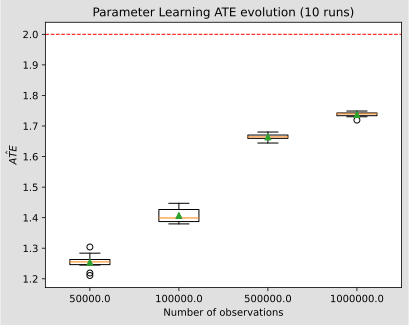

In [16]:
plt.boxplot(pl_tau_hat_arr, labels=num_obs_list, meanline=False,
            showmeans=True, showcaps=True)
plt.axhline(y=2, color='r', linestyle='--', linewidth=1)
plt.title(f"Parameter Learning ATE evolution ({num_shots} runs)")
plt.xlabel("Number of observations")
plt.ylabel(r"$\hat{ATE}$")
plt.show()

### 3 - Structure Learning

As before, the structure learning can be performed on discretized variables derived from the data or by specifying the variables to be used in the process.

In [17]:
discretized_s_template = getBN(data=df, add_arcs=False)

In [18]:
disc_s_learner = gum.BNLearner(df, discretized_s_template)
disc_s_learner.useNMLCorrection()
disc_s_learner.useSmoothingPrior(1e-6)
disc_s_learner.setSliceOrder([["X3"], ["X1","X2","V1","V2","V3"], ["T"], ["Y"]])
disc_slbn = disc_s_learner.learnBN()

print(disc_s_learner)

Filename               : /tmp/tmptscpugew.csv
Size                   : (1000000,8)
Variables              : X1[10], X2[10], X3[2], T[2], V1[10], V2[10], V3[2], Y[60]
Induced types          : False
Missing values         : False
Algorithm              : MIIC
Score                  : BDeu  (Not used for constraint-based algorithms)
Correction             : NML  (Not used for score-based algorithms)
Prior                  : Smoothing
Prior weight           : 0.000001
Constraint Slice Order : {T:2, X2:1, V3:1, V1:1, Y:3, X3:0, X1:1, V2:1}



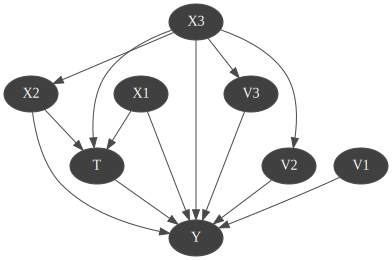

In [19]:
gnb.showBN(disc_slbn, size="50")

In [20]:
gnb.sideBySide(gnb.getInference(mutilateBN(disc_slbn), evs={"T":0}, size="10"),
               gnb.getInference(mutilateBN(disc_slbn), evs={"T":1}, size="10"),
               captions=["Y(0)", "Y(1)"]) 

print(f"{ATE(disc_slbn) = }")

ATE(disc_slbn) = 1.5951486751551684


The structure learning algorithm using discretized variables performs worse than the parameter learning algorithm, as evidenced by the greater bias of the ATE. We anticipate an even less favorable estimation when utilizing the custom template.

In [21]:
custom_s_template = getBN(fill_distribution=False, add_arcs=False)

In [22]:
cstm_s_learner = gum.BNLearner(df, custom_s_template)
cstm_s_learner.useNMLCorrection()
cstm_s_learner.useSmoothingPrior(1e-6)
cstm_s_learner.setSliceOrder([["X3"], ["X1","X2","V1","V2","V3"], ["T"], ["Y"]])
cstm_slbn = cstm_s_learner.learnBN()

print(cstm_s_learner)

Filename               : /tmp/tmp5f66w194.csv
Size                   : (1000000,8)
Variables              : X1[10], V1[10], X2[10], V2[10], X3[2], V3[2], T[2], Y[60]
Induced types          : False
Missing values         : False
Algorithm              : MIIC
Score                  : BDeu  (Not used for constraint-based algorithms)
Correction             : NML  (Not used for score-based algorithms)
Prior                  : Smoothing
Prior weight           : 0.000001
Constraint Slice Order : {V2:1, V1:1, T:2, X3:0, Y:3, X1:1, X2:1, V3:1}



In [23]:
gnb.sideBySide(gnb.getInference(mutilateBN(cstm_slbn), evs={"T":0}, size="10"),
               gnb.getInference(mutilateBN(cstm_slbn), evs={"T":1}, size="10"),
               captions=["Y(0)", "Y(1)"]) 

print(f"{ATE(cstm_slbn) = }")

ATE(cstm_slbn) = 1.5851052588033687


Again, let's evaluate the evolution of the estimated ATE. 

In [25]:
template = custom_s_template

num_obs_list = [5e4, 1e5, 5e5, 1e6]
num_shots = 10
sl_tau_hat_arr = list()

for i in num_obs_list:
    sl_tau_hat_arr.append(list())
    for j in range(num_shots):
        df = generate_lunceford(int(i))

        s_learner = gum.BNLearner(df, template)
        s_learner.useNMLCorrection()
        s_learner.useSmoothingPrior(1e-6)
        s_learner.setSliceOrder([["X3"], ["X1","X2","V1","V2","V3"], ["T"], ["Y"]])
        slbn = s_learner.learnBN()

        sl_tau_hat_arr[-1].append(ATE(slbn))

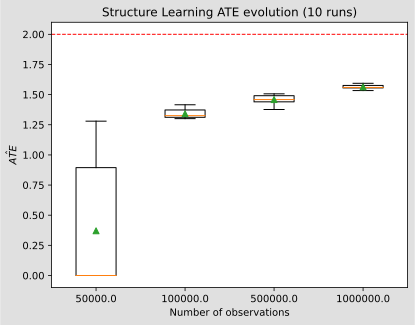

In [27]:
plt.boxplot(sl_tau_hat_arr, labels=num_obs_list, meanline=False,
            showmeans=True, showcaps=True)
plt.axhline(y=2, color='r', linestyle='--', linewidth=1)
plt.title(f"Structure Learning ATE evolution ({num_shots} runs)")
plt.xlabel("Number of observations")
plt.ylabel(r"$\hat{ATE}$")
plt.show()